In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
def qftDagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [10]:
def qft(n):
    qft_circuit = QuantumCircuit(n)
    for i in range((n - 1), -1, -1):
        qft_circuit.h(i)
        for j in range((i - 1), -1, -1):
            qft_circuit.cp(np.pi / (2 ** (i - j)), j, i)
            qft_circuit.barrier()

    for i in range( int(n / 2) ):
        qft_circuit.swap(i , (n - 1 - i))
        
    qft_circuit.barrier()
    qft_circuit.name = "QFT"
    return qft_circuit

def qft_dagger(n):
    qft_dagger_circuit = QuantumCircuit(n)
    
    for i in range( int(n / 2) ):
        qft_dagger_circuit.swap(i , (n - 1 - i))
    
    for i in range((n - 1), -1, -1):
        for j in range((i - 1), -1, -1):
            qft_dagger_circuit.cp(-np.pi / (2 ** (j - i)), i, j)
        qft_dagger_circuit.barrier()
        qft_dagger_circuit.h(i)

        
    qft_dagger_circuit.barrier()
    qft_dagger_circuit.name = "QFT†"
    return qft_dagger_circuit

def oracle(n):
    q_orc = QuantumCircuit(n)
    q_orc.name = "Shor's Oracle"
    return q_orc


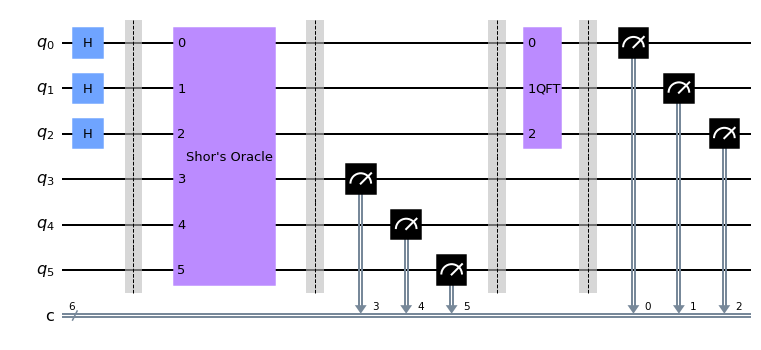

In [17]:
n = 6

qCirc = QuantumCircuit(n,n)
for i in range(3):
    qCirc.h(i)
    
qCirc.barrier()
    
qCirc.append(oracle(n), range(n))

qCirc.barrier()

qCirc.measure([3,4,5], [3,4,5])

qCirc.barrier()
    
qCirc.append(qft(3), range(3))

qCirc.barrier()

for i in range(3):
    qCirc.measure(i,i)

qCirc.draw()

In [1]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qCirc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Traceback (most recent call last):
  Input In [1] in <cell line: 1>
    aer_sim = Aer.get_backend('aer_simulator')
NameError: name 'Aer' is not defined

Use %tb to get the full traceback.


In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  01000000(bin) =  64(dec)   64/256 = 0.25


In [10]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.00      0/1            1
2   0.75      3/4            4
3   0.25      1/4            4
